In [ ]:
# регресія
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Regression

## EDA

In [ ]:
# Завантажимо набір даних і попередньо переглянемо:
data_path = 'https://raw.githubusercontent.com/alexvekh/DL-course/main/data/ConcreteStrengthData.csv'
df = pd.read_csv(data_path)

In [ ]:
df.sample(5, random_state=42)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
31,266.0,114.0,0.0,228.0,0.0,932.0,670.0,365,52.91
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
136,389.9,189.0,0.0,145.9,22.0,944.7,755.8,28,74.50
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
918,145.0,0.0,179.0,202.0,8.0,824.0,869.0,28,10.54


In [ ]:
df.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [ ]:
# Виведемо базову інформацію про набір даних.
df.info()
# Бачимо 9 ознак. Пропусків нема

# df.isna().sum()     # пеевірка на на наявність пропусків
# df = df.dropna().reset_index(drop=True)     # якщо декілька рядків даних мають пропущені значення. Можемо видалити їх з датасету.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [ ]:
df.corr().style.background_gradient()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
CementComponent,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
BlastFurnaceSlag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
FlyAshComponent,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
WaterComponent,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
SuperplasticizerComponent,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
CoarseAggregateComponent,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
FineAggregateComponent,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
AgeInDays,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
Strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


## Feature preprocessing

In [ ]:
# Train/test split
# Представимо матрицю ознак X та вектор таргетової змінної y як numpy-масив.
X = df.drop('Strength', axis =1)#.values
y = df['Strength']#.values

In [ ]:
y

,Strength
0,79.99
1,61.89
2,40.27
3,41.05
4,44.30
...,...
1025,44.28
1026,31.18
1027,23.70
1028,32.77


In [ ]:
# Розділимо дані на тренувальні та тестові.
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Бачимо, що ознаки набору даних дуже розрізнені в своєму числовому представленні.
# Щоб гарантувати, що ознаки будуть представлені в одному масштабі, використаємо StandardScaler.
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [ ]:
X_train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
900,150.0,237.0,0.0,174.0,12.0,1069.0,675.0,28
370,218.9,0.0,124.1,158.5,11.3,1078.7,794.9,14
604,339.0,0.0,0.0,197.0,0.0,968.0,781.0,365
973,143.8,136.3,106.2,178.1,7.5,941.5,774.3,28
593,252.5,0.0,0.0,185.7,0.0,1111.6,784.3,7
...,...,...,...,...,...,...,...,...
87,286.3,200.9,0.0,144.7,11.2,1004.6,803.7,3
330,246.8,0.0,125.1,143.3,12.0,1086.8,800.9,14
466,190.3,0.0,125.2,166.6,9.9,1079.0,798.9,100
121,475.0,118.8,0.0,181.1,8.9,852.1,781.5,28


## Modeling

In [ ]:
class BigmartDataset(Dataset):
    def __init__(self, X, y, scale=True):
        self.X = X.values # from Pandas DataFrame to NumPy array
        self.y = y.values

        if scale:
            sc = StandardScaler()
            self.X = sc.fit_transform(self.X)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset

        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return X, y

# Створимо об’єкти навчального та тестового Dataset
train_dataset = BigmartDataset(X_train, y_train)
test_dataset = BigmartDataset(X_test, y_test)

In [ ]:
# Створимо об’єкти DataLoader для наших Dataset-ів.
train_dataloader = DataLoader(train_dataset,
                              batch_size=200,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=200,
                              num_workers=0
                             )

In [ ]:
# X, y = train_dataset[0]  # Access the first element
# print(X, y)

tensor([-1.2470,  1.8272, -0.8006, -0.3848,  0.9808,  1.2080, -1.1914, -0.2958]) tensor(37.4300)


In [ ]:
# Щоб переконатись, що батч даних коректно генерується, використаємо наступний запис коду:
#  Для нас важливо переконатись, що DataLoader коректно повертає дані перед тим, як ми почнемо процес навчання моделі.
next(iter(train_dataloader))

[tensor([[-1.2470,  1.8272, -0.8006,  ...,  1.2080, -1.1914, -0.2958],
         [-0.6137, -0.8646,  1.1712,  ...,  1.3314,  0.3049, -0.5233],
         [ 0.4901, -0.8646, -0.8006,  ..., -0.0767,  0.1314,  5.1800],
         ...,
         [-0.3067, -0.8646,  0.7692,  ...,  0.1751,  1.4791, -0.7020],
         [ 0.5820, -0.8646, -0.8006,  ...,  0.9282,  0.4434, -0.2958],
         [-1.0990, -0.8646,  1.7941,  ...,  1.0757,  0.1202,  0.1592]]),
 tensor([37.4300, 26.0500, 38.8900, 26.1500, 11.4800, 33.0600, 15.6900, 67.3100,
         28.6300, 32.0700, 39.4500, 39.2300, 39.3800, 27.3400, 31.5400, 41.3000,
         58.8000, 45.0800, 51.7200, 55.5100, 23.8500, 68.7500, 53.1000, 15.0300,
         67.7000, 17.5800, 39.9400, 24.5000, 11.9600, 67.1100, 79.9900, 23.3500,
         33.9400, 17.5400, 13.0900, 57.2300, 19.9900, 23.7400, 44.8700, 65.2000,
         56.4000, 12.7900, 23.7000, 33.6900, 32.7200, 40.6000, 28.9900, 82.6000,
         63.5300, 17.2200, 29.8700, 71.9900, 31.2700, 52.2000, 34.6700, 

In [ ]:
# Створимо клас, який буде описувати нашу нейронну мережу.
class LinearModel(torch.nn.Module):              # Клас LinearModel: Це клас, який наслідує від torch.nn.Module, що дозволяє створити нейронну мережу у PyTorch.
    def __init__(self, in_dim, out_dim=1):       # Конструктор __init__(): Тут визначається структура нейронної мережі, яку створює PyTorch.
        super().__init__()                          # in_dim — це кількість вхідних ознак, тобто розмірність вхідного вектора.
                                                    # out_dim=1 — це кількість вихідних одиниць, що зазвичай використовується в задачах регресії.
        self.features = torch.nn.Sequential(    # У конструкторі створюється послідовність шарів (покроково через torch.nn.Sequential):
            nn.Linear(in_dim, 256),             # Перший шар: nn.Linear(in_dim, 256) — лінійний шар, що перетворює вхідні дані з розміру in_dim на 256 елементів.
            torch.nn.ReLU(),                    # функції активації ReLU (torch.nn.ReLU()), щоб додати нелінійність між шарами.

            nn.Linear(256, 128),                    # Можна змінити кількість нейронів у шарах, наприклад, збільшити чи зменшити значення 256, 128, 64.
            torch.nn.ReLU(),                        # Замість ReLU можна використовувати інші функції активації, наприклад, torch.nn.Sigmoid(), torch.nn.Tanh() (наприклад, для класифікації).
                                                    # Інші шари: Якщо задача складніша, можна додавати шари для нормалізації, наприклад, BatchNorm1d(), або шари Dropout для боротьби з перенавчанням.
            nn.Linear(128, 64),                     # Якщо це задача класифікації, можна змінити останній шар, щоб отримати більше виходів (наприклад, для багатокласової класифікації).
            torch.nn.ReLU(),                        # За замовчуванням PyTorch використовує стандартну ініціалізацію ваг, але інколи корисно експериментувати з різними стратегіями ініціалізації, наприклад, через torch.nn.init.

            nn.Linear(64, out_dim),             # Останній лінійний шар: nn.Linear(64, out_dim) — це вихідний шар, що дає прогноз або ймовірність.
        )

    def forward(self, x):                       # Це основна частина, де здійснюється проходження через нейронну мережу.
        output = self.features(x)               # Вхідний тензор x проходить через всі шари мережі, описані в self.features, і повертається результат.
        return output

# Ця задача є складнішою відносно класифікації, тому ми створимо мережу з більшою кількістю шарів та більшою кількістю нейронів у кожному шарі.
# Зверніть увагу, що останнім є лінійний шар Linear.
# Це зумовлено тим, що для вирішення задачі регресії ми передбачаємо фактичні значення цільової змінної. Отже, не потребуємо функції активації.
# В якості метрики точності продовжимо використовувати RMSE. Вона є оптимальною для оцінки якості моделювання цієї задачі.
# Ініціалізація моделі, функції втрат та алгоритму оптимізації аналогічні до прикладу багатокласової класифікації.

In [ ]:
# Ініціалізація моделі, функції втрат та алгоритму оптимізації аналогічні до прикладу багатокласової класифікації.

# Initialize the model # створюється екземпляр класу LinearModel
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  # кількість вхідних ознак (характеристик) в тренувальній вибірці
  # out_dim=1 — оскільки це задача регресії, ми прогнозуємо одне значення (наприклад, ціну), тому вихідний шар має 1 одиницю.

# Define the loss function and optimizer
criterion = nn.MSELoss()  # criterion = nn.MSELoss() — це функція втрат (або помилка), яка використовується для задачі регресії.
              # МSE (Mean Squared Error) обчислює середньоквадратичну похибку між прогнозами та реальними значеннями.
# Основні функції втрат:
  # - MSELoss (Mean Squared Error Loss): (Застосовується в задачах регресії. Обчислює середню квадратичну помилку між передбаченими значеннями та істинними.
  #     Використовується, коли важливо мінімізувати великі помилки.
  # - MAELoss (Mean Absolute Error Loss): (Також використовується в задачах регресії. Обчислює середню абсолютну різницю між передбаченими значеннями та істинними.
  #     Більш стійка до викидів, порівняно з MSE.
  # - Huber Loss: Компроміс між MSE та MAE, особливо корисний для задач з аномаліями. Використовує квадратичну функцію для малих помилок та лінійну для великих.
  # - CrossEntropyLoss: Найпоширеніша функція втрат для задач класифікації. Вимірює відмінність між передбаченою та істинною ймовірністю для класів.
  # - Binary Cross Entropy (BCE): Застосовується в задачах бінарної класифікації, щоб виміряти відмінність між бінарними передбаченнями та істинними значеннями.

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # оптимізатор Adam використовує параметри моделі для оновлення ваг.
              # lr=1e-4 задає швидкість навчання, тобто наскільки швидко будуть коригуватися параметри під час навчання.
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
              # momentum=0.9 — додатковий параметр, який допомагає покращити сходження, особливо в задачах з великими змінами градієнтів.
              # SGD може вимагати більшої кількості епох для досягнення хороших результатів, порівняно з Adam, але іноді він сприяє кращій узагальнювальній здатності моделі та меншому переоблаштуванню.

# Крім Adam та SGD, у PyTorch для оптимізації нейронних мереж доступні ще кілька ефективних оптимізаторів:
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)   # RMSprop: Створений для прискорення оптимізації в задачах з великою кількістю змін у градієнтах.
              # Принцип: Нормалізує градієнти за рахунок використання середнього квадратичного значення попередніх градієнтів.
              # Це дозволяє покращити сходження в задачах з нерівномірною швидкістю зміни функції втрат.
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)    # AdamW (Adam with Weight Decay):
              # Призначення: Подібний до Adam, але враховує вагове затухання (weight decay), що допомагає зменшити переоблаштування моделі.
              # Принцип: Забезпечує регуляризацію на ваги, що дозволяє оптимізувати за критерієм Adam, але з ваговим затуханням.
# optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-4)  # Adagrad:
              # Призначення: Оптимізатор, що підлаштовує швидкість навчання для кожного параметра окремо.
              # Принцип: Для параметрів, які рідше змінюються, швидкість навчання зменшується повільніше, що дозволяє збалансувати градієнти для різних параметрів.
# optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)   # Adadelta:
              # Призначення: Удосконалення Adagrad, яке обмежує збільшення накопичення градієнтів.
              # Принцип: Використовує відносні зміни у градієнтах, зменшуючи вплив великих значень градієнтів.
# Nadam (Nesterov-accelerated Adam):
              # Призначення: Версія Adam, яка використовує прискорення Нестерова.
              # Принцип: Поєднує адаптивну швидкість навчання Adam та інерцію Нестерова для прискореного сходження.
              # У PyTorch немає прямої реалізації, але її можна знайти в сторонніх бібліотеках або створити власну.
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)     # LBFGS (Limited-memory Broyden–Fletcher–Goldfarb–Shanno):
            # Призначення: Потужний оптимізатор другого порядку для невеликих моделей.
            # Принцип: Використовує матрицю Гессе (наближено) для обчислення градієнтів. Використовується у випадках, коли потрібно точніше і швидше знайти оптимум для невеликих нейронних мереж.

  # Adam/AdamW: Загальне рішення, яке працює добре для більшості задач, особливо з великим обсягом даних.
  # SGD з моментумом: Корисний для великих мереж; дозволяє краще уникати локальних мінімумів.
  # RMSprop: Підходить для рекурентних нейронних мереж (RNN) або задач з високою варіативністю градієнтів.
  # LBFGS: Застосовується, коли потрібно точне рішення для невеликих мереж або специфічних задач.
  # Вибір оптимізатора залежить від задачі, обсягу даних, та архітектури нейронної мережі.

train_losses = []   # Ініціалізація списків для збереження результатів
test_losses = []    # (для збереження значень втрат (loss) і кореня середньоквадратичної помилки (RMSE) для тренувальної та тестової вибірки протягом усіх етапів навчання.)
train_rmses = []
test_rmses = []

# В якості функції втрат використаємо Mean Squared Error. В PyTorch цю loss-функцію реалізовано як MSELoss.
# Для вирішення цієї задачі ми використаємо інший алгоритм оптимізації, а саме Adam. Деталі його реалізації та порівняння з алгоритмом SGD ми розберемо у наступній темі.
# Кроки навчання моделі є ідентичними до минулого прикладу, тому одразу запишемо цикл навчання.



# Цикл навчання (Training Loop)
num_epochs = 100

for epoch in range(num_epochs):

    # Train step

    model.train()

    y_pred_train = []

    for data in train_dataloader:                           # Дані з train_dataloader обробляються батчами.
        # Get and prepare inputs
        inputs, targets = data                                # Розділяємо вхідні дані (inputs) та цільові значення (targets).
        inputs, targets = inputs.float(), targets.float()     # Застосовуємо метод float() до даних для сумісності з PyTorch (моделі працюють з тензорами типу float32).
        targets = targets.reshape((targets.shape[0], 1))
        # Forward pass
        outputs = model(inputs)                               # Виконуємо прямий прохід через модель: outputs = model(inputs).
        loss = criterion(outputs, targets)                    # Обчислюємо втрати: loss = criterion(outputs, targets).

        # Backward pass and optimization
        optimizer.zero_grad()                                 # Обнуляємо градієнти оптимізатора: optimizer.zero_grad().
        loss.backward()                                       # Обчислюємо градієнти для втрат через loss.backward().
        optimizer.step()                                      # Обчислюємо градієнти для втрат через loss.backward().

        y_pred_train.extend(outputs.cpu().detach().numpy())

    if (epoch+1) % 10 == 0:                                   # Кожні 10 епох виводиться поточна втрата та RMSE для тренувальної вибірки.
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {RMSE(y_train, y_pred_train)}')
    train_rmses.append(RMSE(y_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())

# метрики оцінювання
  # - Root Mean Squared Error (RMSE): Корінь з MSE, що повертає помилку у тих самих одиницях, що й цільова змінна, і є більш інтерпретованим для практичного використання.
  # - Mean Squared Logarithmic Error (MSLE): Корисна для регресійних задач, де передбачувані та фактичні значення змінюються у великих діапазонах або є позитивними, оскільки обмежує вплив великих відхилень для відносних оцінок.
  # - Mean Squared Error (MSE) - більш чутлива до великих відхилень (викидів), оскільки враховує квадрат помилки. Використовується тоді, коли критично виявити та мінімізувати великі помилки.
  #     from sklearn.metrics import mean_squared_error
  #     mse = mean_squared_error(y_true, y_pred)
  # - Mean Absolute Error (MAE) - підходить, якщо вам важливо мати стабільну оцінку помилки незалежно від викидів, оскільки вона менш чутлива до великих помилок.
  #   Її значення простіше інтерпретувати, оскільки показує середнє абсолютне відхилення у тих же одиницях, що і цільова змінна.
  #     from sklearn.metrics import mean_absolute_error
  #     mae = mean_absolute_error(y_true, y_pred)
  # - R-Squared (R²) - показує, яку частку варіації у цільовій змінній модель пояснює. Значення, близьке до 1, свідчить про високу точність, і ця метрика зручна для порівняння різних моделей на одному наборі даних.
  #     from sklearn.metrics import r2_score
  #     r2 = r2_score(y_true, y_pred)



    # Eval step

    model.eval()

    y_pred_test = []

    with torch.no_grad():                                     # В режимі оцінки (model.eval()), ми не оновлюємо ваги, тому використовуємо torch.no_grad() для економії пам'яті.

        for data in test_dataloader:
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Forward pass
            outputs = model(inputs)                           # Прогнозуємо на тестових даних (outputs = model(inputs)), обчислюємо втрати для тестової вибірки та зберігаємо прогнози.
            loss = criterion(outputs, targets)

            # No backward pass

            y_pred_test.extend(outputs.cpu().detach().numpy())

        # Виведення результатів для тестової вибірки (Обчислюємо RMSE та втрата для тестових даних та додаємо їх до відповідних списків.)
        test_rmses.append(RMSE(y_test, y_pred_test))
        test_losses.append(loss.cpu().detach().numpy())
        # В кінці навчання ми маємо список значень втрат і RMSE для тренувальної та тестової вибірок, які можна використовувати для оцінки якості моделі.
        # Зверніть увагу, що в цьому випадку ми маємо цикл в циклі. Це відбувається через те, що ми послідовно ітеруємось батчами даних.
        # Відповідно одна епоха проходить, коли модель побачить всі тренувальні/тестові дані, тобто проітерується усіма батчами.

Epoch [10/100], Loss: 1548.9608, RMSE: 39.5030415412151
Epoch [20/100], Loss: 1469.7463, RMSE: 38.49320833221313
Epoch [30/100], Loss: 1276.1608, RMSE: 35.874506547406426
Epoch [40/100], Loss: 946.0671, RMSE: 30.873071864560615
Epoch [50/100], Loss: 562.0740, RMSE: 23.76861825414084
Epoch [60/100], Loss: 313.6678, RMSE: 17.9128490181428
Epoch [70/100], Loss: 236.6651, RMSE: 15.944003419929437
Epoch [80/100], Loss: 215.3449, RMSE: 15.375885652266671
Epoch [90/100], Loss: 204.2014, RMSE: 15.007095306541528
Epoch [100/100], Loss: 196.2450, RMSE: 14.72536200671909


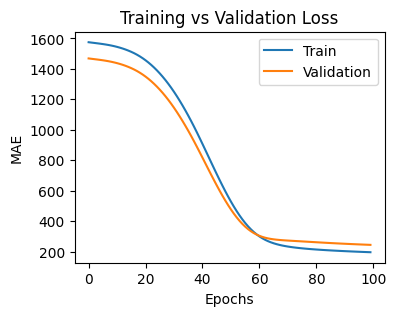

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training vs Validation Loss')
plt.show()

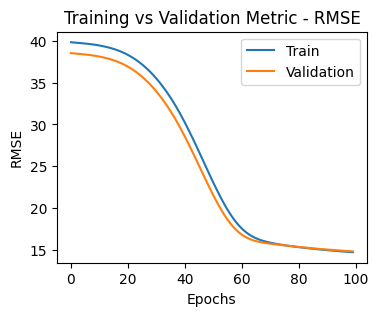

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_rmses, label='Train')
plt.plot(test_rmses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Validation Metric - RMSE')
plt.show()

Під час навчання моделі ми спостерігали позитивну динаміку зменшення функції втрат. Це свідчить про те, що модель поступово навчилася краще узгоджувати свої прогнози з реальними значеннями вхідних даних.

Зниження значення метрики точності є очікуваним результатом у контексті задачі регресії, оскільки стандартні метрики точності часто не застосовні або неінформативні для регресійних задач.

Таким чином, можна зробити висновок, що навчання пройшло успішно, і модель демонструє покращену здатність до прогнозування відповідно до поставленої задачі регресії.

Щоб оцінити важливість ознак у глибокій нейронній мережі, існують інші підходи:

Аналіз чутливості (Sensitivity Analysis): Ви можете обчислити вплив кожної ознаки, варіюючи її значення та спостерігаючи, як змінюються прогнози. Це допоможе визначити, які ознаки найбільше впливають на результат.

Shapley Values (SHAP): Це метод, який розраховує важливість ознак для моделі машинного навчання, зокрема для нейронних мереж. За допомогою бібліотеки shap ви можете отримати оцінки важливості ознак для кожного прогнозу, що дозволяє глибше зрозуміти поведінку моделі.

Permutation Importance: Цей підхід вимірює важливість ознак, випадково перемішуючи значення кожної ознаки та оцінюючи, як це впливає на продуктивність моделі. У бібліотеці sklearn.inspection є метод permutation_importance, який можна використовувати з моделями PyTorch через спеціальні обгортки.

In [ ]:
import shap

# Переводимо модель та дані в режим без градієнтів
model.eval()

# Створюємо об'єкт SHAP для PyTorch моделі
explainer = shap.DeepExplainer(model, torch.tensor(X_train.values, dtype=torch.float32))

# Розраховуємо значення SHAP для тестового набору
shap_values = explainer.shap_values(torch.tensor(X_test.values, dtype=torch.float32))

# Візуалізуємо важливість ознак
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)